# Documentation of Intro to Machine Learning Project.

In [1]:
import sys
import pickle
import numpy as np
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit

## Basic Data Exploration

In [2]:
#Show the most important characteristics of the dataset
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
import pandas as pd
df = pd.DataFrame(data_dict).T

#get total number of data points, total number of features
num_datapoints = df.shape[0]
num_features = df.shape[1] - 1 #I subtracted 1 because POI ins't feature, it is label(class).
print "Total number of data points:", num_datapoints
print "Total number of features:", num_features
print "" #insert blank line

#show the allocation across classes(POI/non-POI)
poi_allocation = df.poi.value_counts()
print "The allocation across classes(POI/non-POI):"
print poi_allocation
print "The proportion of POI:", round(poi_allocation.loc[True] / float(df.poi.count()) * 100, 2), "%"
print "" #insert blank line

#show how many NaNs in each feature
num_NaN_in_each_feature = (df == 'NaN').sum()
print "The number of NaNs in each feature:"
print num_NaN_in_each_feature.sort_values(ascending = False)

Total number of data points: 146
Total number of features: 20

The allocation across classes(POI/non-POI):
False    128
True      18
Name: poi, dtype: int64
The proportion of POI: 12.33 %

The number of NaNs in each feature:
loan_advances                142
director_fees                129
restricted_stock_deferred    128
deferral_payments            107
deferred_income               97
long_term_incentive           80
bonus                         64
from_this_person_to_poi       60
from_poi_to_this_person       60
from_messages                 60
shared_receipt_with_poi       60
to_messages                   60
other                         53
expenses                      51
salary                        51
exercised_stock_options       44
restricted_stock              36
email_address                 35
total_payments                21
total_stock_value             20
poi                            0
dtype: int64


- The data has skewed classses. Therefore it has [class imbalance problem](http://www.chioka.in/class-imbalance-problem/), and it would be better to use recall as evaluation metric rather than accuracy or precision. 

- When considering the number of NaN values of each feature, it would be better to use features like total_stock_value and total_payments rather than loan_advances, director_fees and restricted_stock_deferred.

In [3]:
#To know the formats of the names in the data, print 10 names.
n = 0
for data_point in data_dict:
    if n == 10:
        break
    print data_point
    n += 1

METTS MARK
BAXTER JOHN C
ELLIOTT STEVEN
CORDES WILLIAM R
HANNON KEVIN P
MORDAUNT KRISTINA M
MEYER ROCKFORD G
MCMAHON JEFFREY
HORTON STANLEY C
PIPER GREGORY F


- When I found about ['METTS MARK'](http://money.cnn.com/2006/04/05/news/newsmakers/enron_blog_fortune/), METTS is surname and MARK is first name. And when I also found about ['BAXTER JOHN C'](https://en.wikipedia.org/wiki/J._Clifford_Baxter), BAXTER is surname and JOHN is first name and C is abbreviation of middle name. Therefore it looked like that the names in the data have the surname + first name format or surname + first name + one letter of abbreviation of middle name format.

## 1. Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?

- The goal of this project is to build a person of interest identifier based on financial and email data made public as a result of the Enron scandal. And machine learning can be useful in this case because it can detect hidden patterns in the data using its features better than humans.

- In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. The key people of the scancal were Jeff Skilling, Kenneth Lay and Andrew Fastow. Jeff Skilling was the chairman of the Enron board of directors. Kenneth Lay was the CEO of Enron during most of the time that fraud was being perpetrated. Andrew Fastow was CFO (chief financial officer) of Enron during most of the time that fraud was going on. They were sentenced to imprisonment. There is a high possibility that their data appear as outliers.

In [4]:
#I made scatter_plot_for_two_features function to see if there is any outlier.
def scatter_plot_for_two_features(data_dict, feature1, feature2):
    '''
    This function is to draw scatter plot of 2 features and show the distribution of POIs and Non-POIs.
    
    Inputs: 1) data_dict(type:dict) - data typed dictionary.  
            2, 3) feature1, feature2(type:str) - features of the data whose distribution or relation between them you want to see 
    
    Output: None
    
    In the process of function draw scatter plot of 2 features colored by each label.
    Label is automatically designated as 'poi'.
    '''
    #first element in features_list should be label. In this function, it is 'poi'.
    features_list = ['poi', feature1, feature2]

    data = featureFormat(data_dict, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)

    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    for i in range(len(labels)):
        point_feature1 = features[i][0]
        point_feature2 = features[i][1]

        if labels[i] == True:
            c = 'red'
        else:
            c = 'blue'
        plt.scatter(point_feature1, point_feature2, c = c, alpha = 0.7)
        
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    
    red_patch = mpatches.Patch(color = 'red', label = 'POI')
    blue_patch = mpatches.Patch(color = 'blue', label = 'Non-POI')
    plt.legend(handles = [red_patch, blue_patch])
    plt.title('Enron data scatter plot')

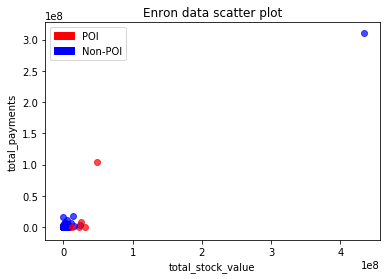

In [5]:
#See the scatter plot of total_stock_value and total_payments.
#I'm going to see the distribution of total_stock_value and total_payments.
#I chose them because they have least NaNs.
scatter_plot_for_two_features(data_dict, 'total_stock_value', 'total_payments')

There are 2 outliers. I need to check who they are.

In [6]:
#I'm going to filter outliers by total_payments.
for data_point in data_dict:
    total_payment = data_dict[data_point]['total_payments']
    if total_payment != 'NaN':
        if total_payment >= 10**8:
            print 'Name:', data_point
            print 'Total_payments:', total_payment
            print '' #insert blank line.

Name: LAY KENNETH L
Total_payments: 103559793

Name: TOTAL
Total_payments: 309886585



Kenneth Lay's information need to remain because it is freak but meaningful event. But TOTAL needs to be deleted because it isn't a person's data.

I just searched for outliers related with 'total_stock_value' and 'total_payments' features. I'm going to find if there is any other outlier using name format.

In [7]:
import re
for data_point in data_dict:
    if re.match(r'^\w+ \w+( \w)?$', data_point) == None:
        print data_point

WALLS JR ROBERT H
SULLIVAN-SHAKLOVITZ COLLEEN
BOWEN JR RAYMOND M
OVERDYKE JR JERE C
PEREIRA PAULO V. FERRAZ
BLAKE JR. NORMAN P
THE TRAVEL AGENCY IN THE PARK
TOTAL
WHITE JR THOMAS E
WINOKUR JR. HERBERT S
GARLAND C KEVIN
YEAGER F SCOTT
DERRICK JR. JAMES V
DONAHUE JR JEFFREY M
GLISAN JR BEN F


There are some names whose format I didn't expect. But I found that there are 2 names which aren't related with person. One is 'TOTAL' and the other is 'THE TRAVEL AGENCY IN THE PARK'. I'm goint to delete the latter one too.

In [8]:
#Delete TOTAL from data_dict using pop function.
data_dict.pop('TOTAL', 0)

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

In [9]:
#Delete THE TRAVEL AGENCY IN THE PARK from data_dict using pop function.
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

Now I'm going to use scatter_plot_for_two_features again to see the distribution of POIs and non_POIs.

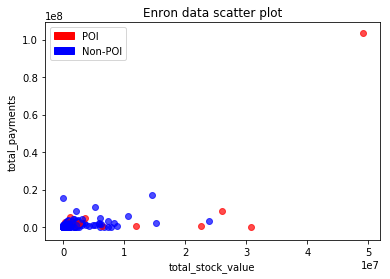

In [10]:
#Use scatter_plot_for_two_features again after deleting 'TOTAL'.
scatter_plot_for_two_features(data_dict, 'total_stock_value', 'total_payments')

It is still a little hard to see it because of Kenneth Lay's data, but it became a little better to see the distribution of POIs.

## 2. What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.

- My own feature that I want to attempt to engineer is 'total_stock_value_without_deferred'. It can be calculated by adding restricted_stock value and exercised_stock_options value. I got to know that Enron executives emphasized a lot about stock price and they did all they could do to increase the price. Therefore I expect that POIs chose to own lots of stocks to earn rapidly growing money and to show that Enron's stocks don't have any problem. But when I see the result of feature importances, its value is low.

In [11]:
#add 'total_stock_value_without_deferred' feature to data_dict.
for name, data in data_dict.iteritems():
    restricted_stock = data['restricted_stock']
    exercised_stock_options = data['exercised_stock_options']
    if restricted_stock != 'NaN' and exercised_stock_options != 'NaN':
        data['total_stock_value_without_deferred'] = restricted_stock + exercised_stock_options
    else:
        data['total_stock_value_without_deferred'] = 'NaN'

Divide features and labels from data_dict.

In [12]:
#I got feature names from data_dict's inner dictianary's keys.
#And I removed and added 'poi' because it is label and it should be first element in the 'features_list'.
#I also removed 'email_address' because featureFormat function can't deal with string values.
feature_names = data_dict['LAY KENNETH L'].keys()
feature_names.remove('poi')
feature_names.remove('email_address')

features_list = ['poi'] + feature_names

data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

I made show_feature_importances function to see the feature importances for each classifier algorithm.

In [13]:
def show_feature_importances(clf, feature_names):
    '''
    This function is to show feature names and their importances. 
    This function can be helpful to decide which features to use when fitting a classifier.
    
    Input: 1) clf - The classifier whose feature importances you want to see.
                    But to use the function, classifiers need to have feature_importances_ attribute.
                    Therefore, the kind of classifiers are limited to DecisionTreeClassifier, ExtraTreesClassifier, 
                    RandomForestClassifier, AdaBoostClassifer, etc.
                    Before clf is entered to show_feature_importances function, clf needs to be fitted already. 
           
           2) feature_names(type:list) - A list which has the names of features(without label name).
           
    Process: Make list of importances using feature_importances_ attribute.
             Make list of tuples by zipping feature_names and importances.
             And sort the tuples by importances in descending order.
             Finally print each feature name and its importance.
    
    Output: None
    '''
    importances = clf.feature_importances_
    feature_importance_tuples = zip(feature_names, importances)
    sorted_tuples = sorted(feature_importance_tuples, key = lambda tup : tup[1], reverse = True)
    sorted_names = zip(*sorted_tuples)[0]
    sorted_importances = zip(*sorted_tuples)[1]
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    x_pos = np.arange(len(sorted_names)) 

    plt.xticks(x_pos, sorted_names, rotation = 90) 
    plt.ylabel('Feature Importances')
    plt.bar(x_pos, sorted_importances, align='center')

Feature importances for adaboost classifier.

> I'm going to use 'other' feature only because feature importance decrease a lot from 'other' to 'exercised_stock_options'. But if the result of using only 'other' isn't good, I'll try using 'exercised_stock_options' too because it is the second best feature.

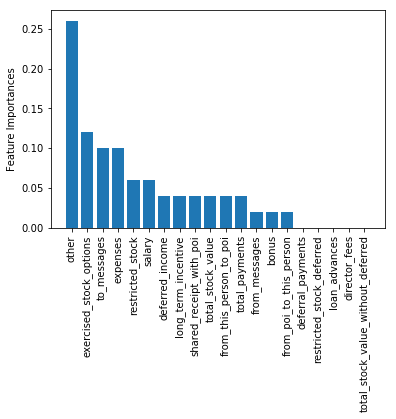

In [14]:
from sklearn.ensemble import AdaBoostClassifier

adaboostClf = AdaBoostClassifier(random_state = 42)
adaboostClf.fit(features, labels)

show_feature_importances(adaboostClf, feature_names)

Feature importances for randomforest classifier.

> I'm going to use 'exercised_stock_options' feature only because feature importance decrease a lot from 'exercised_stock_options' to 'total_payments'. But if the result of using only 'exercised_stock_options' isn't good, I'll try using 'total_payments' too because it is the second best feature.

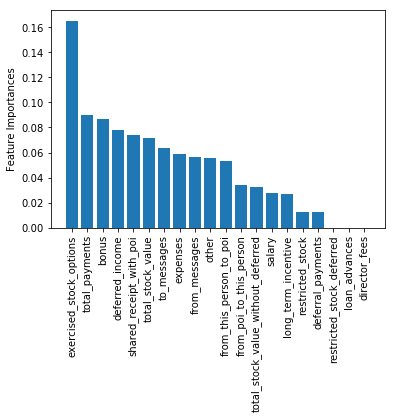

In [15]:
from sklearn.ensemble import RandomForestClassifier

rfClf = RandomForestClassifier(random_state = 42)
rfClf.fit(features, labels)

show_feature_importances(rfClf, feature_names)

Feature importances for decisiontree classifier.

> I'm going to use 'expenses' and 'exercised_stock_options' features because feature importance decrease a lot from 'exercised_stock_options' to 'bonus'. But if the result of using the 2 features isn't good, I'll try using 'bonus' too because it is the third best feature.

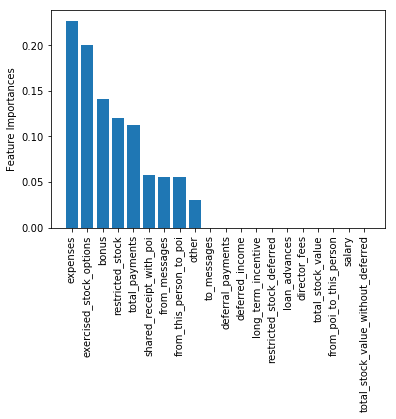

In [16]:
from sklearn.tree import DecisionTreeClassifier

dtClf = DecisionTreeClassifier(random_state = 42)
dtClf.fit(features, labels)

show_feature_importances(dtClf, feature_names)

## 3. What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms? 

- I tried DecisionTreeClassifier, RandomForestClassifer and AdaBoostClassifier. And I finally decided to use DecisionTreeClassifier.

I made traintestsplit_gridsearchcv_evaluation function to validate, tune, train and test at a time. With the function and its results I answered question 3 to 6.

In [17]:
def stratifiedshufflesplit_gridsearchcv_evaluation(clf, parameters, refit, features, labels):
    '''
    This function is after receiving raw classifier to validate with StratifiedShuffleSplit, tune with GridSearchCV and 
    return tuned and fitted classifier.
    
    Input: 1) clf - The classifier you want to tune with GridSearchCV.
                    Before clf is entered to this function, raw classifier without setting parameters needs to be made already. 
                    
           2) parameter(type:dict) - the dictionary of parameters of the classifier. 
                                     The key should be parameter name and the value should be list of experimental parameter values.
                                     GridSearchCV will decide the optimal parameters using the values in the list.
                                     
           3) refit(type: string) - For multiple metric evaluation of GridSearchCV, this needs to be a string denoting 
                                    which scorer is used to find the best parameters for refitting the estimator at the end.
                                    I designated GridSearchCV's scorers as accuracy, precision, and recall. Therefore, one of the 
                                    3 scorers need to selected.
           
           4) features(type:list of arrays) - features of the data. Each element of the list is a data point whose type should be an array.
                                              Each data point's feature values need to be in the array.            
           
           5) labels(type:list) -  labels or classes of data points.
           
           
    Process: Use StratifiedShuffleSplit to split features and labels to train set and test set without class imbalance problem. 
             I chose to assign 30% of data to test set and iterating reshuffling and spliting 100 times.
             And use GridSearchCV to tune the parameters of classifier.
             Get accuracy, precision and recall using fitted the classifier's cv_results_ values.
             Finally return classifier and accuracy, precision, and recall values.
             
    Output: cv_clf - tuned and fitted classifier, you can get to know the attributes like best_params_, etc.
                     And if you want to get mean values of accuracy, precision, recall scores of the classifier,
                     you can use cv_results_ attribute. They are mean values from 100 training and testing data sets.
                     

        example) The case of using AdaBoostClassifier and featureFormat, targetFeatureSplit functions.

        features_list_for_adaboost = ['poi', 'other']

        data_for_adaboost = featureFormat(data_dict, features_list_for_adaboost, sort_keys = True)
        labels_for_adaboost, features_for_adaboost = targetFeatureSplit(data_for_adaboost)

        adaboostClf = AdaBoostClassifier()
        adaboost_parameters = {'n_estimators' : [20, 35, 50, 65, 80]}
        
        ###designated refit parameter as accuracy.
        cv_adaboost = traintestsplit_gridsearchcv_evaluation(adaboostClf, adaboost_parameters, 'accuracy', \
                                                             features_for_adaboost, labels_for_adaboost)
        
        ###To get the index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.
        adaboost_index = cv_clf.best_index_
        
        ###To get the parameter setting that gave the best results on the hold out data.
        print 'Best parameter setting:', cv_clf.best_params_
        
        ###To get the mean accuracy, precision, and recall values of test data sets by the tuned classifier.
        adaboost_results = cv_clf.cv_results_
        mean_accuracy = adaboost_results['mean_test_accuracy'][adaboost_index]
        mean_precision = adaboost_results['mean_test_precision'][adaboost_index]
        mean_recall = adaboost_results['mean_test_recall'][adaboost_index]
        
        print 'Average accuracy of tuned AdaBoostClassifier:', mean_accuracy
        print 'Average precision of tuned AdaBoostClassifier:', mean_precision
        print 'Average recall of tuned AdaBoostClassifier:', mean_recall
    '''
    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import make_scorer
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    
    sss = StratifiedShuffleSplit(n_splits = 100, test_size = 0.3, random_state = 42)
    
    scoring = {'accuracy' : make_scorer(accuracy_score),
               'precision' : make_scorer(precision_score),
               'recall' : make_scorer(recall_score)}
    cv_clf = GridSearchCV(clf, parameters, cv = sss, scoring = scoring, refit = refit)
    cv_clf.fit(features, labels)
    
    return cv_clf

**I don't need to do feature scaling because DecisionTree, AdaBoost and RandomForest Classifiers aren't affected by it.**

**I'm going to designate refit parameter in the traintestsplit_gridsearchcv_evaluation function as 'recall'. I chose 'recall' because as I said before, this Enron data has class imbalance problem.**

In [18]:
def from_enron_data_to_results(features_list, classifier_name, classifier_parameters, refit):
    '''
    This function is to receive enron data and yield tuned classifier and its evaluation results using machine learning.
    
    Input: 1) features_list(type:list) - features of the enron data which will enter into the classifier to tune, train and test.
                                         First element should be 'poi'.

           2) classifier_name(type:str) - The name of the classifier you want to tune with GridSearchCV.
                                          But the kind of classifiers are limited to DecisionTreeClassifier, ExtraTreesClassifier, 
                                          RandomForestClassifier, and AdaBoostClassifer.
                                          When you enter classifier_name, it should be 'decisiontree' or 'extratrees' or 
                                          'randomforest' or 'adaboost'.
                                          
           3) classifier_parameters(type:dict) - the dictionary of parameters of the classifier. 
                                     The key should be parameter name and the value should be list of experimental parameter values.
                                     GridSearchCV will decide the optimal parameters using the values in the list.
                                     
           4) refit(type: string) - For multiple metric evaluation of GridSearchCV, this needs to be a string denoting 
                                    which scorer is used to find the best parameters for refitting the estimator at the end.
                                    I designated GridSearchCV's scorers as accuracy, precision, and recall. Therefore, one of the 
                                    3 scorers need to selected.
           
    Process: Use featureFormat and targetFeatureSplit functions to get features and labels data from enron data.
             Make classifier as classifier_name designated.
             And use stratifiedshufflesplit_gridsearchcv_evaluation function to apply StratifiedShuffleSplit and GridSearchCV
             functions to the classifier and features and labels.
             Finally, print the tuned and fitted classifier's best parameters, mean accuracy, precision and recall values and
             return the classifier.
    
    Use StratifiedShuffleSplit to split features and labels to train set and test set without class imbalance problem. 
             I chose to assign 30% of data to test set and iterating reshuffling and spliting 100 times.
             And use GridSearchCV to tune the parameters of classifier.
             Get accuracy, precision and recall using fitted the classifier's cv_results_ values.
             Finally return classifier and accuracy, precision, and recall values.
             
    Output: cv_clf - tuned and fitted classifier. In the process of this function, best parameters, mean accuracy, precision, 
                     and recall values are printed. But there are still other attributes you can find with cv_clf. And above all, 
                     you can use cv_clf to fit and predict independent data sets.          
                  
    '''
    data = featureFormat(data_dict, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    
    if classifier_name == 'adaboost':
        from sklearn.ensemble import AdaBoostClassifier
        clf = AdaBoostClassifier()
    elif classifier_name == 'randomforest':
        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier()
    elif classifier_name == 'decisiontree':
        from sklearn.tree import DecisionTreeClassifier
        clf = DecisionTreeClassifier()
    elif classifier_name == 'extratrees':
        from sklearn.ensemble import ExtraTreesClassifier
        clf = ExtraTreesClassifier()
    else:
        raise ValueError('classifier_name should be "adaboost" or "randomforest" or "decisiontree" or "extratrees".')
        
    cv_clf = stratifiedshufflesplit_gridsearchcv_evaluation(clf, classifier_parameters, refit, features, labels)

    #get the index of the best parameter setting
    clf_index = cv_clf.best_index_

    #get the parameter setting that gave the best results on the hold out data.
    print 'Best parameter setting:', cv_clf.best_params_

    #get the mean accuracy, precision, and recall values of test data sets by the tuned classifier.
    results = cv_clf.cv_results_
    mean_accuracy = results['mean_test_accuracy'][clf_index]
    mean_precision = results['mean_test_precision'][clf_index]
    mean_recall = results['mean_test_recall'][clf_index]

    print 'Average accuracy of tuned {} classifier:'.format(classifier_name), mean_accuracy
    print 'Average precision of tuned {} classifier:'.format(classifier_name), mean_precision
    print 'Average recall of tuned {} classifier:'.format(classifier_name), mean_recall
    
    return cv_clf

The result of AdaBoost classifier.

> Accuracy was highest of all three classifiers. But both of precision and recall values are lower than or equal to 0.5.

In [19]:
features_list_for_adaboost = ['poi', 'other']
adaboost_parameters = {'n_estimators' : [20, 35, 50, 65, 80]}

cv_adaboost = from_enron_data_to_results(features_list_for_adaboost, 'adaboost', adaboost_parameters, 'recall')

C:\Users\JehyeonHeo\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameter setting: {'n_estimators': 65}
Average accuracy of tuned adaboost classifier: 0.638571428571
Average precision of tuned adaboost classifier: 0.172203102453
Average recall of tuned adaboost classifier: 0.188333333333


In [22]:
features_list_for_adaboost2 = ['poi', 'other', 'exercised_stock_options']
adaboost_parameters = {'n_estimators' : [20, 35, 50, 65, 80]}

cv_adaboost2 = from_enron_data_to_results(features_list_for_adaboost2, 'adaboost', adaboost_parameters, 'recall')

Best parameter setting: {'n_estimators': 20}
Average accuracy of tuned adaboost classifier: 0.804473684211
Average precision of tuned adaboost classifier: 0.371642857143
Average recall of tuned adaboost classifier: 0.298333333333


The result of RandomForest classifier.
> All values of accuracy, precision and recall are lower than AdaBoost classifier's result.

In [20]:
features_list_for_rf = ['poi', 'exercised_stock_options']
rf_parameters = {'n_estimators' : [20, 35, 50, 65, 80], 'min_samples_split' : [2, 5, 10, 15]}

cv_rf = from_enron_data_to_results(features_list_for_rf, 'randomforest', rf_parameters, 'recall')

Best parameter setting: {'min_samples_split': 5, 'n_estimators': 65}
Average accuracy of tuned randomforest classifier: 0.836451612903
Average precision of tuned randomforest classifier: 0.386095238095
Average recall of tuned randomforest classifier: 0.2925


In [20]:
features_list_for_rf2 = ['poi', 'exercised_stock_options', 'total_payments']
rf_parameters = {'n_estimators' : [20, 35, 50, 65, 80], 'min_samples_split' : [2, 5, 10, 15]}

cv_rf2 = from_enron_data_to_results(features_list_for_rf2, 'randomforest', rf_parameters, 'recall')

Best parameter setting: {'min_samples_split': 5, 'n_estimators': 65}
Average accuracy of tuned randomforest classifier: 0.836451612903
Average precision of tuned randomforest classifier: 0.386095238095
Average recall of tuned randomforest classifier: 0.2925


The result of DecisionTree classifier.
> Accuracy was lowest of all three classifiers. And precision is also low. But recall is really high compared to the others.

In [21]:
features_list_for_dt = ['poi', 'exercised_stock_options', 'expenses']
dt_parameters = {'min_samples_split' : [2, 5, 10, 15], 'criterion' : ['gini', 'entropy']}

cv_dt = from_enron_data_to_results(features_list_for_dt, 'decisiontree', dt_parameters, 'recall')

Best parameter setting: {'min_samples_split': 2, 'criterion': 'gini'}
Average accuracy of tuned decisiontree classifier: 0.794358974359
Average precision of tuned decisiontree classifier: 0.238179154179
Average recall of tuned decisiontree classifier: 0.312


In [23]:
features_list_for_dt2 = ['poi', 'exercised_stock_options', 'expenses', 'bonus']
dt_parameters = {'min_samples_split' : [2, 5, 10, 15], 'criterion' : ['gini', 'entropy']}

cv_dt2 = from_enron_data_to_results(features_list_for_dt2, 'decisiontree', dt_parameters, 'recall')

Best parameter setting: {'min_samples_split': 2, 'criterion': 'gini'}
Average accuracy of tuned decisiontree classifier: 0.838
Average precision of tuned decisiontree classifier: 0.399814935065
Average recall of tuned decisiontree classifier: 0.462


## 4. What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier). 

- Tuning the parameters of an algorithm makes optimal classifier of the algorithm. If I don't tune it well, the result of the classifier can be overfitting or underfitting and the evaluation metrics show lower performances of it.

- I tuned 'min_samples_split' and 'criterion' paramters using GridSearchCV.

## 5. What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?

- Validation is the process that a trained model is evaluated with a testing data set to test the generalization ability of the trained model. It aims to find an optimal model with the best performance. And data analysts should be careful of the situation that evaluation result is good for training set, and bad for testing set in validation process because there's a high possibility that the classifier is overfitted. In the case, it is likely that the results of application of the classifier to the independent data sets aren't good.

- I validated using StratifiedShuffleSplit function. I assigned 30% of data to test set and 70% of data to train set. And I cross-validated the classifier by iterating reshuffling and splitting 10 times.

## 6. Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance.

- I used precision, and recall as evaluation metrics. And when I ran DecisionTreeClassifier 10 times, the average performance for each of them are 0.27, 0.83.
- I got accuracy too, but it doesn't mean much in this case because labels had skewed classes.
- Precision is 'True Positive / (True Positive + False Positive)'. I got precision as 0.27, it means that when the classifier predicted that a data point is POI, then only 27% of them are correct.
- Recall is 'True Positive / (True Positive + False Negative)'. I got recall as 0.83, it means that from all POIs in the data points, the classifier detected 83% of them.
- With the classifier, if it detects POIs, most of real POIs are detected. But it is unlikely that detected data points are real POIs because lots of non-POIs are detected, too.

### References
- basic resource : https://github.com/udacity/ud120-projects
- Udacity Intro to Machine Learning course : https://www.udacity.com/course/intro-to-machine-learning--ud120
- enron scandal wikipedia page : https://en.wikipedia.org/wiki/Enron_scandal
- machine learning algorithms and evaluation functions : http://scikit-learn.org/stable/index.html
- validation : https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-9863-7_233

I hereby confirm that this submission is my work. I have cited above the origins of any parts of the submission that were taken from Websites, books, forums, blog posts, github repositories, etc.